# Starbucks Capstone Challenge - Predictive and Modelling

## Introduction

Offer Selection

* Remove unsuccessful offers
* Strip the ID and perform a classifier

Receives Offer or Not

* Receives offer if, offer successful and total spent is 20 (10 from promo, + additional product) 

Combination of both will give better results in incremental profit and IRR.

## Setup

In [1]:
import sys

!{sys.executable} -m pip install -e ../ --quiet

ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: C:\ProgramData\scoop\apps\vscode


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sb_capstone.wrangling import (
    clean_transcript_group
)

from sb_capstone.graph import (
    plot_corr    
)

%matplotlib inline

In [3]:
transcript_group = pd.read_csv("../data/processed/transcript_group.csv")
transcript_group = clean_transcript_group(transcript_group)

transcript_group.head()

,id,wave,diffs,received,viewed,completed,purchased,amount,reward,non_offer_amount,...,mobile,social,gender,age,generation,group,income,membership_year,membership_month,membership_day
0,1,2,48.000000,True,True,False,False,0.00,0.0,0.00,...,True,False,U,NaN,NaN,NaN,NaN,2017,2,12
1,2,2,49.866737,False,False,False,False,0.00,0.0,0.00,...,False,False,F,55.0,boomers,middle_age,112000.0,2017,7,15
2,3,2,36.000000,True,True,False,False,0.00,0.0,0.00,...,True,False,U,NaN,NaN,NaN,NaN,2018,7,12
3,4,2,26.000000,True,True,True,True,19.67,0.0,29.72,...,True,True,F,75.0,silent,old,100000.0,2017,5,9
4,5,2,49.866737,False,False,False,True,0.00,0.0,3.50,...,False,False,U,NaN,NaN,NaN,NaN,2017,8,4


In [4]:
transcript_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102000 entries, 0 to 101999
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   id                102000 non-null  int64   
 1   wave              102000 non-null  int64   
 2   diffs             102000 non-null  float64 
 3   received          102000 non-null  bool    
 4   viewed            102000 non-null  bool    
 5   completed         102000 non-null  bool    
 6   purchased         102000 non-null  bool    
 7   amount            102000 non-null  float64 
 8   reward            102000 non-null  float64 
 9   non_offer_amount  102000 non-null  float64 
 10  mapped_offer      102000 non-null  category
 11  offer_type        102000 non-null  category
 12  difficulty        102000 non-null  float64 
 13  duration          102000 non-null  float64 
 14  web               102000 non-null  bool    
 15  email             102000 non-null  bool    
 16  mo

## Q3. How can we make use of the result to improve the app using machine learning?

Based on our analysis, we found out that giving out these offers randomly can make customers spends more, however, only the discount revenue are the ones providing us revenue. On the other hand, the offers themselves are not good enough to improve customer's response to avail the offer.

Let's look at how we can is to distinguish which demographic are affected by the offers and to those who still spends for the product without the offer.

In [5]:
transcript_group[transcript_group.id == 3]

,id,wave,diffs,received,viewed,completed,purchased,amount,reward,non_offer_amount,...,mobile,social,gender,age,generation,group,income,membership_year,membership_month,membership_day
2,3,2,36.000000,True,True,False,False,0.00,0.0,0.00,...,True,False,U,NaN,NaN,NaN,NaN,2018,7,12
17002,3,3,49.866737,False,False,False,True,0.00,0.0,1.64,...,False,False,U,NaN,NaN,NaN,NaN,2018,7,12
34002,3,4,49.866737,False,False,False,True,0.00,0.0,5.09,...,False,False,U,NaN,NaN,NaN,NaN,2018,7,12
51002,3,5,49.866737,False,False,False,False,0.00,0.0,0.00,...,False,False,U,NaN,NaN,NaN,NaN,2018,7,12
68002,3,6,64.000000,True,False,True,False,2.14,0.0,4.09,...,True,True,U,NaN,NaN,NaN,NaN,2018,7,12
85002,3,1,49.866737,False,False,False,True,0.00,0.0,1.34,...,False,False,U,NaN,NaN,NaN,NaN,2018,7,12


Let's analyze a bit who should be given out with offers.

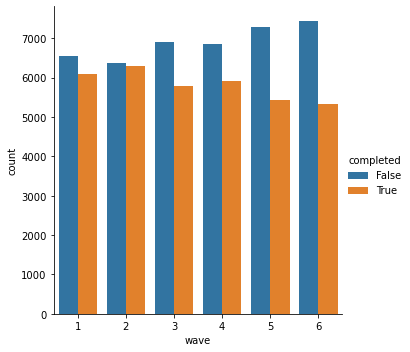

In [6]:
sns.catplot(data=transcript_group[transcript_group.received], kind="count", x="wave", hue="completed");

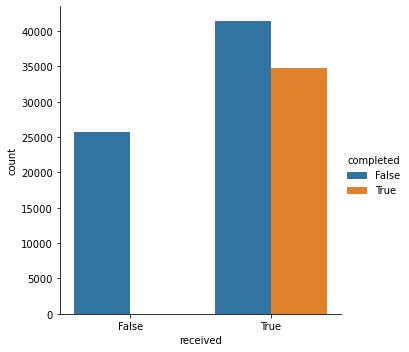

In [7]:
sns.catplot(data=transcript_group, kind="count", x="received", hue="completed");

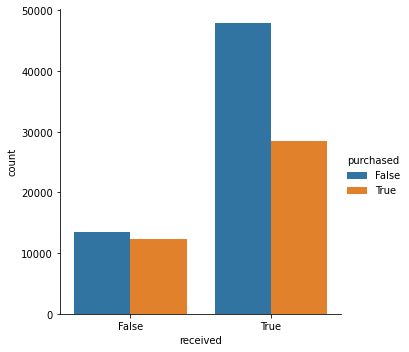

In [8]:
sns.catplot(data=transcript_group, kind="count", x="received", hue="purchased");

In [9]:
def _convert_gender(gender):
    if gender == "M":
        return 1.0
    elif gender == "F":
        return 0.0
    else:
        return np.NaN

def _transform_bools(transcript_group):
    transcript_group["received"] = transcript_group["received"].astype(int)
    transcript_group["viewed"] = transcript_group["viewed"].astype(int)
    transcript_group["completed"] = transcript_group["completed"].astype(int)
    transcript_group["purchased"] = transcript_group["purchased"].astype(int)
    transcript_group["web"] = transcript_group["web"].astype(int)
    transcript_group["email"] = transcript_group["email"].astype(int)
    transcript_group["mobile"] = transcript_group["mobile"].astype(int)
    transcript_group["social"] = transcript_group["social"].astype(int)

    return transcript_group

def _transform_offers(transcript_group):

    offer_dummies = pd.get_dummies(transcript_group.mapped_offer)
    offer_dummies.columns = offer_dummies.columns.astype(str)
    transcript_group = transcript_group.drop(columns=["mapped_offer"])

    transcript_group = pd.concat([transcript_group, offer_dummies], axis=1)

    return transcript_group

def _transform_offer_types(transcript_group):
    offer_type_dummies = pd.get_dummies(transcript_group.offer_type)
    transcript_group = transcript_group.drop(columns=["offer_type"])

    transcript_group = pd.concat([transcript_group, offer_type_dummies], axis=1)

    return transcript_group

def _transform_gender(transcript_group):
    transcript_group.gender = transcript_group.gender.apply(_convert_gender)

    return transcript_group

def _transform_generation(transcript_group):
    gen_dummies = pd.get_dummies(transcript_group.generation)
    transcript_group = transcript_group.drop(columns=["generation"])

    transcript_group = pd.concat([transcript_group, gen_dummies], axis=1)

    return transcript_group

def _transform_age_group(transcript_group):
    group_dummies = pd.get_dummies(transcript_group.group)
    transcript_group = transcript_group.drop(columns=["group"])

    transcript_group = pd.concat([transcript_group, group_dummies], axis=1)

    return transcript_group

def convert_for_training(transcript_group):
    return _transform_age_group(
        _transform_generation(
            _transform_gender(
                _transform_offer_types(
                    _transform_offers(
                        _transform_bools(transcript_group))))))

In [10]:
data = convert_for_training(transcript_group)
data.head()

,id,wave,diffs,received,viewed,completed,purchased,amount,reward,non_offer_amount,...,no_offer,gen_z,millenials,gen_x,boomers,silent,young,adult,middle_age,old
0,1,2,48.000000,1,1,0,0,0.00,0.0,0.00,...,0,0,0,0,0,0,0,0,0,0
1,2,2,49.866737,0,0,0,0,0.00,0.0,0.00,...,1,0,0,0,1,0,0,0,1,0
2,3,2,36.000000,1,1,0,0,0.00,0.0,0.00,...,0,0,0,0,0,0,0,0,0,0
3,4,2,26.000000,1,1,1,1,19.67,0.0,29.72,...,0,0,0,0,0,1,0,0,0,1
4,5,2,49.866737,0,0,0,1,0.00,0.0,3.50,...,1,0,0,0,0,0,0,0,0,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102000 entries, 0 to 101999
Data columns (total 46 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                102000 non-null  int64  
 1   wave              102000 non-null  int64  
 2   diffs             102000 non-null  float64
 3   received          102000 non-null  int32  
 4   viewed            102000 non-null  int32  
 5   completed         102000 non-null  int32  
 6   purchased         102000 non-null  int32  
 7   amount            102000 non-null  float64
 8   reward            102000 non-null  float64
 9   non_offer_amount  102000 non-null  float64
 10  difficulty        102000 non-null  float64
 11  duration          102000 non-null  float64
 12  web               102000 non-null  int32  
 13  email             102000 non-null  int32  
 14  mobile            102000 non-null  int32  
 15  social            102000 non-null  int32  
 16  gender            87

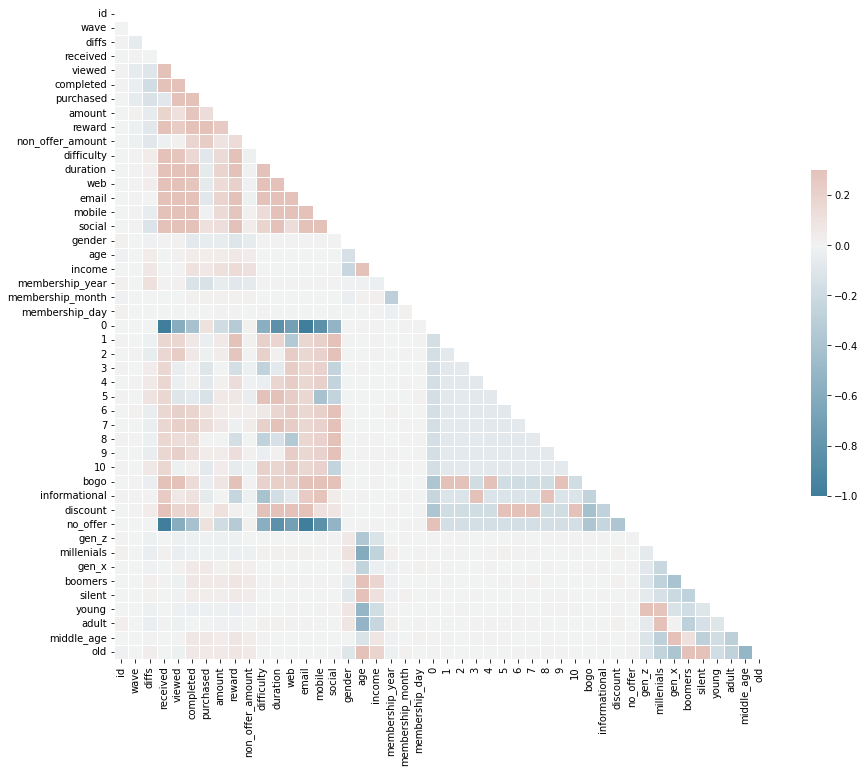

In [12]:
plot_corr(data.corr())

In [13]:
data[data.received == 1].id.nunique()

16994

For the first part, we need things that relates to the customer, as we are going try to check if the customer may respond to the offer. At this point, we are just going to respond based on the demography of the customer.

Also, it'll be useless to add the anonymous customers for our training data, so we are going to remove them as well.

Aside from that, we are also going to limit the data to those who received offer only and how they reacted to it. This way we'll now if it's effective or not.

In [14]:
cols = [
    "purchased",
    "gender",
    "age",
    "income",
    "membership_year",
    "membership_month",
    "membership_day",
    "gen_z",
    "millenials",
    "gen_x",
    "boomers",
    "silent",
    "young",
    "adult",
    "middle_age",
    "old"
]

data = data[~data.age.isna() & data.received][cols]

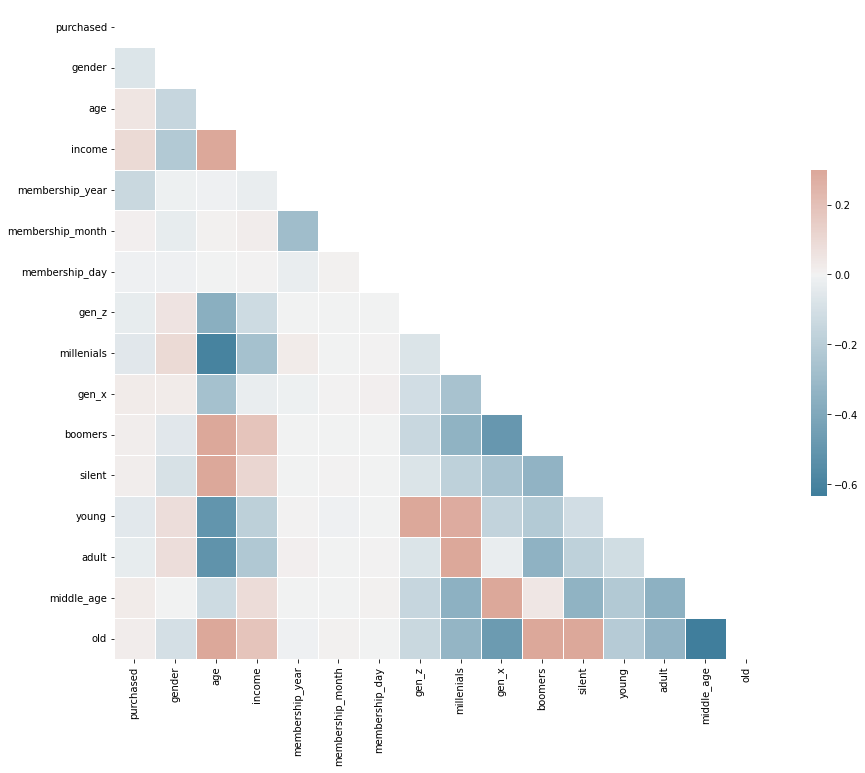

In [15]:
plot_corr(data.corr())

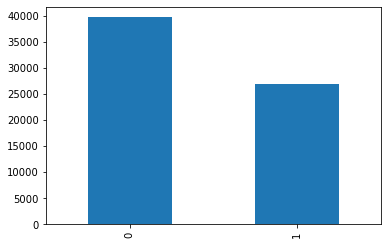

In [16]:
data.purchased.value_counts().plot(kind="bar");

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(initial_strategy="most_frequent")
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

In [18]:
data.head()

,purchased,gender,age,income,membership_year,membership_month,membership_day,gen_z,millenials,gen_x,boomers,silent,young,adult,middle_age,old
0,1.0,0.0,75.0,100000.0,2017.0,5.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,1.0,65.0,53000.0,2018.0,2.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,58.0,51000.0,2017.0,11.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,61.0,57000.0,2017.0,9.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,26.0,46000.0,2014.0,2.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66501 entries, 0 to 66500
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   purchased         66501 non-null  float64
 1   gender            66501 non-null  float64
 2   age               66501 non-null  float64
 3   income            66501 non-null  float64
 4   membership_year   66501 non-null  float64
 5   membership_month  66501 non-null  float64
 6   membership_day    66501 non-null  float64
 7   gen_z             66501 non-null  float64
 8   millenials        66501 non-null  float64
 9   gen_x             66501 non-null  float64
 10  boomers           66501 non-null  float64
 11  silent            66501 non-null  float64
 12  young             66501 non-null  float64
 13  adult             66501 non-null  float64
 14  middle_age        66501 non-null  float64
 15  old               66501 non-null  float64
dtypes: float64(16)
memory usage: 8.1 MB


We are going to use a simple logistic regression for this one using `purchased` as response variable.

In [20]:
from sklearn.model_selection import train_test_split

y = data.purchased
X = data.drop(columns=["purchased"])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [22]:
from sklearn.metrics import classification_report

y_true = lr.predict(X_test)

print(classification_report(y_true, y_test))

              precision    recall  f1-score   support

         0.0       0.97      0.59      0.73     16039
         1.0       0.04      0.44      0.07       587

    accuracy                           0.59     16626
   macro avg       0.50      0.52      0.40     16626
weighted avg       0.93      0.59      0.71     16626



Let's feed this to `GridSearchCV`.

In [23]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("clf", LogisticRegression())
])

After trial and error, I selected the top 3 algorithms that yield best results. For this instance, we'll make use of F1-score as this a balance between precision and recall.

In [24]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier

parameters_clf = {
    "clf": [
        LogisticRegression(),
        DecisionTreeClassifier(),
        KNeighborsClassifier()
    ]
}

In [25]:
from sklearn.model_selection import GridSearchCV

cv = GridSearchCV(pipeline, parameters_clf, scoring="f1", verbose=10)
cv.fit(X_train, y_train)
print(cv.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START clf=LogisticRegression()....................................
[CV 1/5; 1/3] END .....clf=LogisticRegression();, score=0.065 total time=   0.0s
[CV 2/5; 1/3] START clf=LogisticRegression()....................................
[CV 2/5; 1/3] END .....clf=LogisticRegression();, score=0.055 total time=   0.0s
[CV 3/5; 1/3] START clf=LogisticRegression()....................................
[CV 3/5; 1/3] END .....clf=LogisticRegression();, score=0.063 total time=   0.0s
[CV 4/5; 1/3] START clf=LogisticRegression()....................................
[CV 4/5; 1/3] END .....clf=LogisticRegression();, score=0.070 total time=   0.0s
[CV 5/5; 1/3] START clf=LogisticRegression()....................................
[CV 5/5; 1/3] END .....clf=LogisticRegression();, score=0.061 total time=   0.0s
[CV 1/5; 2/3] START clf=DecisionTreeClassifier()................................
[CV 1/5; 2/3] END .clf=DecisionTreeClassifier();,

In [26]:
y_true = cv.predict(X_test)

print(classification_report(y_true, y_test))

              precision    recall  f1-score   support

         0.0       0.72      0.65      0.69     10820
         1.0       0.45      0.53      0.49      5806

    accuracy                           0.61     16626
   macro avg       0.59      0.59      0.59     16626
weighted avg       0.63      0.61      0.62     16626



In [27]:
len(y_true), y_true.sum()

(16626, 5806.0)

In [28]:
joblib.dump(cv, "../models/receive_offer.pkl")

['../models/receive_offer.pkl']